In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = sns.load_dataset('titanic')

In [3]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
df.shape

(891, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [6]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.nunique()

survived         2
pclass           3
sex              2
age             88
sibsp            7
parch            7
fare           248
embarked         3
class            3
who              3
adult_male       2
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

## Problems with the dataset 
1. multicolinearity exists , many feature are giving the same kinda info
    1. survived & alive
    2. sex & who & adult_male (mostly)
    3. pclass & class & deck
    4. embarked & embark_town
2. My Words
    1. (survived & alive) & (embarked & embark_town) are pure multicoliner , drop the one whose dtype is object
    2. for (sex & who & adult_male) 
        - for (sex & who) they are exact same , but there is a twist who tells us if it is man , woman or child .
        - all togetherc i.e(sex & who) tells us if a persona gender is male or female and if he is adult male or adult female or child male or child female .
        - so i suggest making a new column named as 'isAdult' 
        - we will use who and sex -> man = 1 , woman = 1 , child = 0
        - and then drop who & adult_male column
        - this way model will know who survive more adult male or female and child male or female . 

In [8]:
df[['alive','survived','alone']].sample(5)

,alive,survived,alone
354,no,0,True
615,yes,1,False
616,no,0,False
387,yes,1,True
268,yes,1,False


In [9]:
df[['sex','who','adult_male']][df['age'].isnull()]

,sex,who,adult_male
5,male,man,True
17,male,man,True
19,female,woman,False
26,male,man,True
28,female,woman,False
...,...,...,...
859,male,man,True
863,female,woman,False
868,male,man,True
878,male,man,True


In [10]:
df['deck'].unique()

[NaN, 'C', 'E', 'G', 'D', 'A', 'B', 'F']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [11]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [12]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [13]:
df = df.drop(columns=['alive','embarked','class'])

In [14]:
df['sex'] = (
    df['sex']
      .str.strip()
      .str.lower()
      .map({'female': 0, 'male': 1})
      .astype(int)
)
df = df.rename(columns={'sex':'isMale'})

In [15]:
df[(df['who'] == 'child') & df['age'].isna()] # this means all missing age is of adult

,survived,pclass,isMale,age,sibsp,parch,fare,who,adult_male,deck,embark_town,alone


In [16]:
# 1️⃣ Flags
df['is_age_missing'] = df['age'].isna().astype(int)

In [17]:
# verify
df['is_age_missing'].value_counts()

is_age_missing
0    714
1    177
Name: count, dtype: int64

In [18]:
# 2️⃣ Age
age_means = df.groupby(['pclass', 'isMale'])['age'].mean()
age_means

pclass  isMale
1       0         34.611765
        1         41.281386
2       0         28.722973
        1         30.740707
3       0         21.750000
        1         26.507589
Name: age, dtype: float64

In [19]:
df['age'] = df['age'].fillna(
    df.groupby(['pclass', 'isMale'])['age'].transform('mean')
)
# FallBack if some age is still remaining 
# df['age'] = df['age'].fillna(df['age'].median())

In [20]:
df[df['embark_town'].isnull()]

,survived,pclass,isMale,age,sibsp,parch,fare,who,adult_male,deck,embark_town,alone,is_age_missing
61,1,1,0,38.0,0,0,80.0,woman,False,B,NaN,True,0
829,1,1,0,62.0,0,0,80.0,woman,False,B,NaN,True,0


In [21]:
# 3️⃣ Embark town
df['embark_town'] = df['embark_town'].fillna(
    df['embark_town'].mode()[0]
)

In [22]:
# 4️⃣ Deck
df['deck'] = (
    df['deck']
      .cat.add_categories('Unknown')
      .fillna('Unknown')
)

> Solution of NaN
1. age 
    - Instead of filling NaN with mean is just Dumb
    - fill with respect of class and gender 
    - ex. a female in class 1 and 3rd might have different mean age 
    - we will also add a indicator or label , so that it knows if the value is real or guessed
2. for 77% missing data in deck
    - create a new categoty as deck is unknown -> 'U'

In [23]:
df.isnull().sum()

survived          0
pclass            0
isMale            0
age               0
sibsp             0
parch             0
fare              0
who               0
adult_male        0
deck              0
embark_town       0
alone             0
is_age_missing    0
dtype: int64

In [24]:
df['isAdult'] = (df['who'] != 'child').astype(int)

In [25]:
df['familySize'] = df['parch'] + df['sibsp'] + 1

In [26]:
df = df.drop(columns=['who','adult_male'])

In [27]:
df['alone'] = df['alone'].astype(int)

In [28]:
df['deck'].unique()

['Unknown', 'C', 'E', 'G', 'D', 'A', 'B', 'F']
Categories (8, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Unknown']

In [29]:
df['fare_log'] = np.log1p(df['fare'])

In [30]:
df.head()

,survived,pclass,isMale,age,sibsp,parch,fare,deck,embark_town,alone,is_age_missing,isAdult,familySize,fare_log
0,0,3,1,22.0,1,0,7.2500,Unknown,Southampton,0,0,1,2,2.110213
1,1,1,0,38.0,1,0,71.2833,C,Cherbourg,0,0,1,2,4.280593
2,1,3,0,26.0,0,0,7.9250,Unknown,Southampton,1,0,1,1,2.188856
3,1,1,0,35.0,1,0,53.1000,C,Southampton,0,0,1,2,3.990834
4,0,3,1,35.0,0,0,8.0500,Unknown,Southampton,1,0,1,1,2.202765


In [31]:
df[(df['fare'] == 0)].shape

(15, 14)

<Axes: xlabel='fare_log', ylabel='Count'>

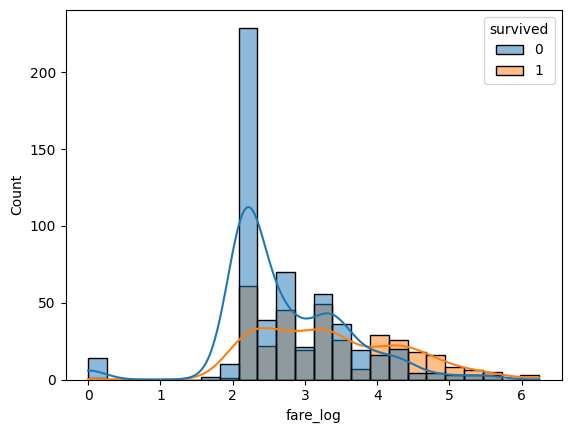

In [32]:
sns.histplot(x=df['fare_log'],kde=True,hue=df['survived'])

In [33]:
X = df.drop(columns=['survived','fare'])
X.shape

(891, 12)

In [34]:
Y = df['survived']
Y.shape

(891,)

- Splitting the data

In [35]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(
    X,Y,
    test_size=0.2,
    random_state=42,
    stratify=Y # Ensures balanced split for classification
    )

In [36]:
x_train.columns

Index(['pclass', 'isMale', 'age', 'sibsp', 'parch', 'deck', 'embark_town',
       'alone', 'is_age_missing', 'isAdult', 'familySize', 'fare_log'],
      dtype='object')

- Encoding

In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore'
).set_output(transform='pandas')

x_train_encoded = encoder.fit_transform(
    x_train[['deck', 'embark_town']]
)

x_test_encoded = encoder.transform(
    x_test[['deck', 'embark_town']]
)

In [38]:
x_train_encoded.shape

(712, 11)

- 👆👆👆👆👆 is Blunder as , we have to manulay concat the remaing and encoded feature 
- here comes 'ColumnTransformatio' comes in action 

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(
            sparse_output=False,
            handle_unknown='ignore'
        ), ['deck', 'embark_town'])
    ],
    remainder='passthrough',   # ⬅️ THIS keeps other columns
    verbose_feature_names_out=False   # 🔥 THIS is For saying 'No to ugly column names'
).set_output(transform='pandas')

x_train_encoded = preprocessor.fit_transform(x_train)
x_test_encoded = preprocessor.transform(x_test)

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

scaler = ColumnTransformer(
    transformers=[
        ('scale',StandardScaler(

        ),['age','fare_log'])
    ],
    remainder='passthrough',   # ⬅️ THIS keeps other columns
    verbose_feature_names_out=False   # 🔥 THIS is For saying 'No to ugly column names'
).set_output(transform='pandas')

x_train_encoded_scaled = scaler.fit_transform(x_train_encoded)
x_test_encoded_scaled = scaler.transform(x_test_encoded)

In [41]:
x_train_encoded_scaled.shape

(712, 21)

### Using single PipeLine

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age','fare_log']),
        ('cat', OneHotEncoder(
            handle_unknown='ignore',
            sparse_output=False
        ), ['deck','embark_town'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

x_train_final = preprocessor.fit_transform(x_train)
x_test_final = preprocessor.transform(x_test)

In [43]:
x_train_final.shape 

(712, 21)

- Manual Training

In [44]:
from sklearn.neighbors import KNeighborsClassifier 

model = KNeighborsClassifier(n_neighbors=5)

model.fit(x_train_final, y_train)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [45]:
y_pred = model.predict(x_test_final)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0])

In [46]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_test_final)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.7597765363128491


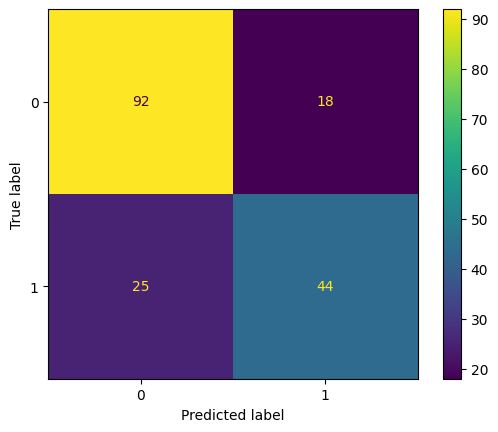

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()
plt.show()

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       110
           1       0.71      0.64      0.67        69

    accuracy                           0.76       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.76      0.76      0.76       179



In [49]:
from sklearn.metrics import roc_auc_score

y_prob = model.predict_proba(x_test_final)[:, 1]
auc = roc_auc_score(y_test, y_prob)

print("ROC-AUC:", auc)

ROC-AUC: 0.7753623188405796


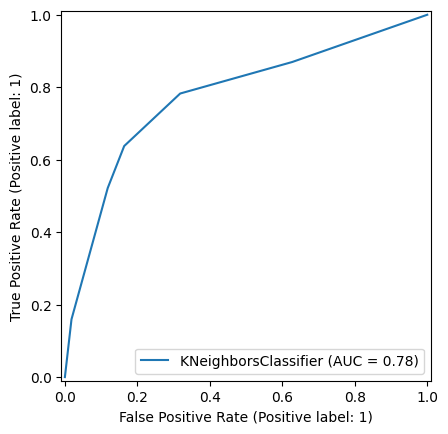

In [50]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
    model, x_test_final, y_test
)
plt.show()

In [51]:
print("Train accuracy:", model.score(x_train_final, y_train))
print("Test accuracy:", model.score(x_test_final, y_test))

Train accuracy: 0.8342696629213483
Test accuracy: 0.7597765363128491
